In [1]:
"""This is identical to the two level explicit, it might look different, 
but that's only because we start with many photons"""

## Import packages
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.offsetbox as offsetbox
import matplotlib.gridspec as gridspec
import math
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [36]:
## Dimensional operators
cav_dim = 2 # total number of possible photons
atm_dim = 2 # energy levels in atom, 2 for TLS
I_cav = qeye(cav_dim) # identity matrix matching dimension of radiation field (2, one for vacuum state, one for excited states)
I_atom = qeye(atm_dim) # identity matrix matching dimension of spin system

## Total atomic operators
sigmap_tot = tensor(sigmap(), I_cav)
sigmam_tot = tensor(sigmam(), I_cav)
sigmaz_tot = tensor(sigmaz(), I_cav)

## Photon operators
adag = create(cav_dim)
a = destroy(cav_dim)
adag_tot = tensor(I_atom, adag) # order of arguments is important and is consistant with the spin operators #add .unit()               
a_tot = tensor(I_atom, a)

## Physical constants
N = 7e14 # number of two-level systems
wa = 2 * np.pi * 1.45e3 # atom transition frequency between levels X & Z (MHz) allows is to work in micro seconds
wc = 2 * np.pi * 1.45e3 # cavity frequency with vacuum field energy set to zero (zero-point energy) (MHz)
gs = 2 * np.pi * 0.042e-6 # collective spin-photon couling strength ~ np.sqrt(tls_num)*g, experimentally it's 1.1 though.
g = 1.5 #2 * np.pi * 1.1 # test spin-photon couling strength ~ np.sqrt(tls_num)*gs, experimetnally it's 1.1 though.

Kc = 0 # 2 * np.pi * 0.18 # cavity mode decay rate (MHz) # derivation can be found in Agarwal pg.31
Ks = 0 #2 * np.pi * 0.11 # spin dephasing rate (MHz)
gamma = 0.2 # 2 * np.pi * 0.0177 # spin-lattice relaxation rate between X and Z

## Initial quantum states
psi_atm = np.sqrt(0.2)*basis(2,0) + np.sqrt(0.8)*basis(2,1) # atom begins in ground state
rho_atm = ket2dm(psi_atm)
psi_phot = np.sqrt(1)*fock(cav_dim, 1) + np.sqrt(0.2)*fock(cav_dim, 0)
#psi_phot = np.sqrt(1)*coherent(cav_dim, np.sqrt(1))
rho_phot = ket2dm(psi_phot)
psi0 = tensor(psi_atm, psi_phot)
rho = tensor(rho_atm, rho_phot)

## Simulation initialization
time = 18.3
steps = 1000
tlist = np.linspace(0, time, steps) # duration and steps to be used in evolution
step_size = tlist[1] - tlist[0]


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


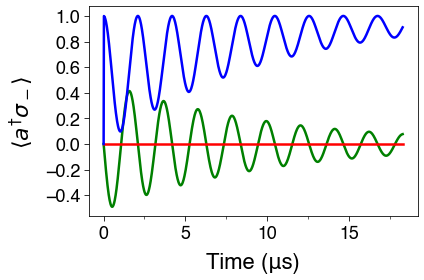

In [3]:
""" Explicit Method """

## Observable initialization
atm_coher_list = [rho.ptrace(0)[0][0][1]] # element 12
phot_coher_list = [rho.ptrace(1)[0][0][1]] # element 12,  has to be this element, because 12*12 is in position 14, which is spin-phot corr
n_phot_list = [((adag * a) * rho.ptrace(1)).tr()] # number of photons in light field

spin_phot_list = [((adag_tot * sigmam_tot) * rho).tr()] # spin-photon correlation


## function computing the Lindblad master equation
def lindblad(p):
    
    ## Assembling the Hamiltonian
    H = g*(sigmap_tot*a_tot + sigmam_tot*adag_tot) # interaction part in the RWA
    
    ## Liouvillian
    closed_system = -1j * commutator(H,p)
    cavity_decay = Kc/2 * (adag_tot*a_tot*p - 2*a_tot*p*adag_tot + p*adag_tot*a_tot)
    spin_relax = gamma/2 * (sigmap_tot*sigmam_tot*p - 2*sigmam_tot*p*sigmap_tot + p*sigmap_tot*sigmam_tot)
    spin_dephase = Ks/2 * (sigmaz_tot.dag()*sigmaz_tot*rho - 2*sigmaz_tot*rho*sigmaz_tot.dag() + rho*sigmaz_tot.dag()*sigmaz_tot)
    
    return closed_system - cavity_decay - spin_relax - spin_dephase


## RK4 method realized using a for loop
for step_index in range(steps-1):
    
    ## RK4 method
    k1 = step_size * lindblad(rho)
    k2 = step_size * lindblad(rho + 0.5*k1)
    k3 = step_size * lindblad(rho + 0.5*k2)
    k4 = step_size * lindblad(rho + k3)
    rho += 1/6*k1 + 1/3*(k2+k3) + 1/6*k4      # calculation of density matrix at n+1 step
    
    
    ## calculating observables at n+1 step using density matrix found above and adding them to list 
    phot_coher_new = rho.ptrace(1)[1][0][0]
    phot_coher_list = np.append(phot_coher_list, phot_coher_new)
    
    atm_coher_new = rho.ptrace(0)[1][0][1]
    atm_coher_list = np.append(atm_coher_list, atm_coher_new)
    
    n_phot_new = (((adag*a) * rho.ptrace(1)).tr().real)
    n_phot_list = np.append(n_phot_list, n_phot_new)
    
    spin_phot_new = ((adag_tot * sigmam_tot) * rho).tr().imag
    spin_phot_list = np.append(spin_phot_list, spin_phot_new)

    

## Visualization 
fig, ax = plt.subplots(figsize=(6,4))
plt.figure(1)
plt.plot(tlist, spin_phot_list, color='g', linestyle='-', linewidth=2.5, zorder=0)
plt.plot(tlist, phot_coher_list, color='r', linestyle='-', linewidth=2.5, zorder=0)
plt.plot(tlist, atm_coher_list, color='b', linestyle='-', linewidth=2.5, zorder=0)
#plt.ylim([-0.57, 0.57])
plt.ylabel(r'$\langle a^\dag \sigma_- \rangle$', labelpad = 10, fontsize = 22)
plt.xlabel('Time (μs)', labelpad = 10, fontsize = 22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0, time+1, 5))
ax.xaxis.set_minor_locator(MultipleLocator(2.5))
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=3)

plt.tight_layout() 
    

In [37]:
rho_atm

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.2 0.4]
 [0.4 0.8]]

In [38]:
rho_phot

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.2       0.4472136]
 [0.4472136 1.       ]]

In [54]:
t = tensor(rho_atm, rho_phot)
t

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.04       0.08944272 0.08       0.17888544]
 [0.08944272 0.2        0.17888544 0.4       ]
 [0.08       0.17888544 0.16       0.35777088]
 [0.17888544 0.4        0.35777088 0.8       ]]

In [44]:
rho_atm[0][0][1] * rho_phot[0][0][1]

(0.17888543819998315+0j)

In [52]:
t.ptrace(0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.24 0.48]
 [0.48 0.96]]